In [1]:
import pandas as pd
import ete3
import re
import community
import networkx as nx
import itertools
import numpy as np
from sklearn import manifold
from scipy.spatial.distance import squareform
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist
import igraph as ig
import plotly
import chart_studio.plotly as ptl
import plotly.graph_objects as go
import colorlover as cl
from IPython.display import HTML
import multiprocessing
import pickle as pkl
import random
from sklearn import mixture
from collections import Counter

ptl.sign_in('lthiberiol', 'm15ikp59lt')
ncbi = ete3.NCBITaxa()
%cd /work/eggNOG/

/work/eggNOG


In [2]:
sampled_genomes = pd.read_csv('/work/kelsey/genomes.tab',
                              sep='\t',
                              index_col=0)

In [3]:
lineages = pd.DataFrame()
for taxid in sampled_genomes.species_taxid.unique():
    if pd.isna(taxid):
        continue
    lineages = lineages.append({tax_rank: tmp_taxid 
                                 for tmp_taxid, tax_rank in ncbi.get_rank(ncbi.get_lineage(taxid)).items()},
                                ignore_index=True)
lineages = lineages.reindex(columns=['class', 'family',  'genus', 'phylum',
                                     'order', 'species', 'superkingdom']).copy()
lineages = lineages.query('superkingdom == 2').copy()

In [4]:
eggNOG_sample = pd.read_csv('e5.bacteria.taxid_info.tsv',
                            sep='\t',
                            comment='#',
                            names=['Taxid', 'Sci.Name', 'Rank', 'Named Lineage', 'Taxid Lineage'],
                            header=None,
                            index_col=0)

In [5]:
eggNOG_lineage = pd.DataFrame()
for taxid in eggNOG_sample.index.unique():
    if pd.isna(taxid):
        continue
    tmp = pd.Series({tax_rank: tmp_taxid 
                     for tmp_taxid, tax_rank in ncbi.get_rank(ncbi.get_lineage(taxid)).items()})
    tmp.name = taxid
    eggNOG_lineage = eggNOG_lineage.append(tmp)

eggNOG_lineage = eggNOG_lineage.reindex(columns=['class', 'family',  'genus', 'phylum',
                                                 'order', 'species', 'superkingdom']).copy()
eggNOG_lineage = eggNOG_lineage.query('superkingdom == 2').copy()

eggNOG_target_phyla = eggNOG_lineage[eggNOG_lineage.phylum.isin(lineages.phylum.unique())]

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning:

taxid 1344012 was translated into 480813

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning:

taxid 443255 was translated into 1901

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning:

taxid 1525715 was translated into 1545044

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning:

taxid 861530 was translated into 29382

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning:

taxid 1317118 was translated into 1379903

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning:

taxid 67281 was translated into 67351

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/

In [6]:
eggNOG_groups = pd.read_csv('2_members.tsv',
                            sep='\t',
                            header=None,
                            usecols=[1,2,3,4],
                            names=['group_id', 'num_proteins', 'num_taxa', 'members'])

tmp           = eggNOG_groups.members.map(lambda cell: [int(taxid) 
                                                        for taxid in re.findall('(\d+)\.(?:[^,]+)', cell)])
tmp.name      = 'taxa'
eggNOG_groups = eggNOG_groups.join(tmp)

In [7]:
def get_phyla_overlap(taxa):
    #taxids = [int(_) for _ in taxa]
    group_phyla = set(eggNOG_lineage.loc[taxa, 'phylum'].unique())
    overlapped_phyla = group_phyla.intersection(lineages.phylum.unique())
    return(overlapped_phyla)

eggNOG_target_groups = eggNOG_groups[eggNOG_groups.taxa.map(lambda cell: 
                                                            True if len(get_phyla_overlap(cell)) > 1 
                                                            else False)]

In [8]:
eggNOG_trees = pd.read_csv('2_trees.tsv',
                           sep='\t',
                           header=None,
                           usecols=[1,2,3],
                           index_col=0,
                           names=['group_id', 'fast', 'tree'])
eggNOG_trees = eggNOG_trees.reindex(index=eggNOG_target_groups.group_id)

In [476]:
eggNOG_chloroflexi = eggNOG_lineage.query('phylum==200795').index
eggNOG_cyano       = eggNOG_lineage.query('phylum==1117'  ).index

chloroflexi_count = eggNOG_target_groups.taxa.map(lambda x: len(eggNOG_chloroflexi.intersection(set(x))))
cyano_count       = eggNOG_target_groups.taxa.map(lambda x: len(eggNOG_cyano.intersection(set(x))))

In [478]:
# groups interesting to test distances between cyano and chloroflexi
test_groups = eggNOG_target_groups[(chloroflexi_count>=10) & (cyano_count>=70)]

In [492]:
test_groups = test_groups[test_groups.num_proteins<5_000]

In [493]:
test_groups.shape

(547, 5)

In [502]:
def get_pairwise_distances(group_id):
    
    tree = ete3.Tree(eggNOG_trees.loc[group_id, 'tree'])

    leaf_names = []
    for count, node in enumerate(tree.traverse()):
        if node.is_leaf():
            leaf_names.append(node.name)
        else:
            node.name = 'node_%i' % count
    leaf_names = np.array(leaf_names)

    nodes         = []
    children      = []
    branch_length = []
    for node in tree.traverse():
        if not node.is_leaf():
            for child in node.get_children():
                nodes.append(         node.name)
                children.append(     child.name)
                branch_length.append(child.dist)

    branch_length_df                  = pd.DataFrame()
    branch_length_df['node']          = nodes
    branch_length_df['child']         = children
    branch_length_df['branch_length'] = branch_length

    dag  = ig.Graph.TupleList(edges=branch_length_df[['node', 
                                                      'child', 
                                                      'branch_length']].itertuples(index=False), 
                                directed=False, 
                                weights=True)
    
    dist_matrix = pd.DataFrame(index  =leaf_names, 
                               columns=leaf_names, 
                               data   =np.array(dag.shortest_paths(source=leaf_names, 
                                                                   target=leaf_names, 
                                                                   weights='weight'))
                              )
    return(dist_matrix)

In [562]:
def create_taxa_graph(dist_matrix, phyla):
    triu_indices       = np.triu_indices_from(dist_matrix, k=1)
    
    edge_list                 = pd.DataFrame()
    edge_list['phylum1']      = phyla[triu_indices[0]]
    edge_list['phylum2']      = phyla[triu_indices[1]]
    edge_list['sequence1']    = dist_matrix.index[triu_indices[0]]
    edge_list['sequence2']    = dist_matrix.index[triu_indices[1]]
    edge_list['distance']     = dist_matrix.values[triu_indices]
    edge_list['inverse_dist'] = np.e**np.negative(edge_list.distance)

    graph  = ig.Graph.TupleList(edges=edge_list[['sequence1', 
                                                 'sequence2', 
                                                 'inverse_dist']].itertuples(index=False), 
                                directed=False, 
                                weights =True)
    
    return(edge_list, graph)

In [542]:
phyla_closeness = {phylum:[] 
                   for phylum in lineages.phylum.unique().astype(int) 
                   if phylum > 0}

closest_data = pd.DataFrame(columns=['phylum', 'eggNOG_id', 'closeness'])

# for group_id in random.sample(test_groups.group_id.to_list(), 5):
for group_id in ['COG0499']:
    print(group_id)
    
    matrix = get_pairwise_distances(group_id)

    taxids = [int(leaf.split('.')[0]) for leaf in matrix.index]
    phyla  = eggNOG_lineage.loc[taxids, 'phylum'].values.astype(int)
    
    edge_list, graph  = create_taxa_graph(dist_matrix)

    clusters = graph.community_multilevel(weights='weight')

    node_data = pd.DataFrame(columns=['name', 'phylum', 'cluster'],
                             data   =zip(matrix.index, 
                                         phyla, 
                                         clusters.membership)
                            )

    family_cyano_count = sum(node_data.phylum==1117)

    for cluster_num in set(clusters.membership):
        cluster_nodes = node_data[node_data.cluster==cluster_num]

        cluster_size = cluster_nodes.shape[0]

        cluster_cyanos = cluster_nodes.loc[cluster_nodes.phylum==1117, 'name']

        if cluster_cyanos.shape[0] < family_cyano_count*0.3:
            continue

        cluster_not_cyanos = cluster_nodes.loc[cluster_nodes.phylum!=1117, 'name']
            
        tmp1 = edge_list.loc[(edge_list.sequence1.isin(cluster_cyanos))&\
                             (edge_list.sequence2.isin(cluster_not_cyanos)),
                             ['phylum2', 'distance']]
        tmp1.rename(columns={'phylum2':'phylum'}, inplace=True)

        tmp2 = edge_list.loc[(edge_list.sequence2.isin(cluster_cyanos))&\
                             (edge_list.sequence1.isin(cluster_not_cyanos)),
                             ['phylum1', 'distance']]
        tmp2.rename(columns={'phylum1':'phylum'}, inplace=True)

        sub_df     = tmp1.append(tmp2)
        normalizer = np.median(sub_df.distance)

        threshold     = np.infty
        closest_phylum = None
        for phylum in sub_df.phylum.unique():
            if sum(cluster_nodes.phylum==phylum) < 5:
                continue

            phylum_3rd_quartile = np.percentile(sub_df.loc[sub_df.phylum==phylum, 
                                                           'distance'].sort_values()[:10], 
                                                75)
            
            if phylum in phyla_closeness:
                phyla_closeness[phylum].append(phylum_3rd_quartile)
                
            if phylum_3rd_quartile < threshold:
                threshold      = phylum_3rd_quartile
                closest_phylum = phylum
            
        if closest_phylum:
            print('  Closest to cyanos: %s (%.4f)' % (closest_phylum, threshold/normalizer))
            
            if closest_phylum in phyla_closeness:
                closest_data = closest_data.append(pd.Series(data =[closest_phylum, group_id,    threshold], 
                                                             index=['phylum',       'eggNOG_id', 'closeness']), 
                                                   ignore_index=True)

COG0499


In [563]:
dist_matrix = get_pairwise_distances('COG0499')

taxids = [int(leaf.split('.')[0]) for leaf in matrix.index]
phyla  = eggNOG_lineage.loc[taxids, 'phylum'].values.astype(int)

edge_list, graph  = create_taxa_graph(dist_matrix, phyla)

clusters = graph.community_multilevel(weights='weight')

In [569]:
%%time

dist_matrix = get_pairwise_distances('COG0499')

taxids = [int(leaf.split('.')[0]) for leaf in dist_matrix.index]
phyla  = eggNOG_lineage.loc[taxids, 'phylum'].values.astype(int)

edge_list, graph  = create_taxa_graph(dist_matrix, phyla)

clusters = graph.community_multilevel(weights='weight')

node_data = pd.DataFrame(columns=['name', 'phylum', 'cluster'],
                         data   =zip(matrix.index, 
                                     phyla, 
                                     clusters.membership)
                        )

family_cyano_count = sum(node_data.phylum==1117)

for cluster_num in set(clusters.membership):
    cluster_nodes = node_data[node_data.cluster==cluster_num]

    if sum(cluster_nodes.phylum==1117) < family_cyano_count*0.3:
        continue
       
    cluster_edges = edge_list.loc[(edge_list.sequence1.isin(cluster_nodes.name))&
                                   (edge_list.sequence2.isin(cluster_nodes.name)),
                                   ['phylum1', 'phylum2', 'distance']]
    normalizer    = np.median(cluster_edges.distance)
    cluster_edges = cluster_edges[cluster_edges.phylum1 != cluster_edges.phylum2] 
    
    phyla_combinations = cluster_edges.groupby(['phylum1', 'phylum2'])

    threshold      = np.infty
    closest_phylum = None
    for (phylum1, phylum2), indices in phyla_combinations.groups.items():
        if indices.shape[0] < 10:
            continue
        if   phylum1 == 1117:
            phylum = phylum2
        elif phylum2 == 1117:
            phylum = phylum1
        else:
            continue

        inter_phyla_dists = cluster_edges.loc[indices, 'distance'].sort_values()[:10]
        phylum_3rd_quartile = np.percentile(inter_phyla_dists, 75)

        if phylum in phyla_closeness:
            phyla_closeness[phylum].append(phylum_3rd_quartile)

        if phylum_3rd_quartile < threshold:
            threshold      = phylum_3rd_quartile
            closest_phylum = phylum

    if closest_phylum:
        print('  Closest to cyanos: %s (%.4f)' % (closest_phylum, threshold/normalizer))

        if closest_phylum in phyla_closeness:
            closest_data = closest_data.append(pd.Series(data =[closest_phylum, group_id,    threshold], 
                                                         index=['phylum',       'eggNOG_id', 'closeness']), 
                                               ignore_index=True)

  Closest to cyanos: 200795 (0.3500)
  Closest to cyanos: 1224 (0.2976)
CPU times: user 11.3 s, sys: 853 ms, total: 12.1 s
Wall time: 11.8 s


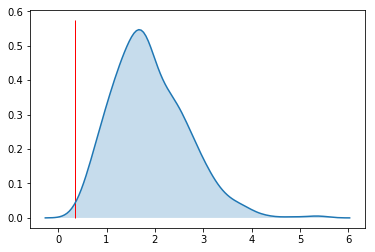

In [488]:
fig, ax = plt.subplots()
sns.kdeplot(phyla_closeness[200795], shade=True, ax=ax)
ax.fill_between(x=[0.3478], y1=ax.get_ylim()[0], y2=ax.get_ylim()[1], color='r')